In [1]:
from model import DenoisingUNet
from utils import *
from data import mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch.nn as nn
import torch

sampleRate = 68.27

## Train - Val - Test sets

In [2]:
train_path = "train"
val_path = "validation"
test_path = "test"
train_files = glob(os.path.join(train_path, '*.npy'))
val_files = glob(os.path.join(val_path, '*.npy'))
test_files = glob(os.path.join(test_path, '*.npy'))

In [3]:
for file in train_files:
    if file in val_files:
        print(f"{file} in validation dataset.")
    elif file in test_files:
        print(f"{file} in test set.")
    else:
        pass

## Hyperparameters

In [2]:
N_sub = 32
batch_size = 32
hidden_layers = 4
learning_rate = 1e-4
num_epochs = 10

## Datasets and DataLoaders

In [5]:
# train_dataset = mask_dataset(data_path='train', f_min=1, f_max=10, N_sub=N_sub, sampleRate=sampleRate)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [6]:
# val_dataset = mask_dataset(data_path='validation', f_min=1, f_max=10, N_sub=N_sub, sampleRate=sampleRate)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [3]:
test_dataset = mask_dataset(data_path='test', f_min = 1, f_max = 10, N_sub=N_sub, sampleRate=sampleRate)
test_loader = DataLoader(test_dataset,batch_size = batch_size,drop_last=True,shuffle = True)

In [5]:
# GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

# model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
# model.to(device)
# Load model trained at synthetic data
model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
state = torch.load('./new_model_tests/synthetic-train.pth')
model.load_state_dict(state['model_state_dict'])
model.train()
model.to(device)
# Mean Square Error 
criterion = nn.MSELoss()

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NVIDIA GeForce RTX 2070
device is cuda:0.


## Training

In [6]:
epochs_losses_train = []
epochs_losses_val = []
for epoch in range(num_epochs):
    print(f"Starting epoch: #{epoch}")
    batch_losses = []
    ## TRAIN ##
    for eval_samples, mask in tqdm(test_loader):
        # to GPU
        mask = mask.to(device)
        eval_samples = eval_samples.to(device)
        # apply mask
        sample = eval_samples * mask.clone().detach()
        sample = torch.unsqueeze(sample.squeeze(), 1)
        # complementary mask
        c_mask = (1-mask).squeeze()

        optimizer.zero_grad()
        # apply complementary mask to output (proj. operator)
        output = model(sample).squeeze()*c_mask
        truth = (eval_samples.squeeze()*c_mask).squeeze()
        loss = criterion(output.squeeze(), truth)
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epochs_losses_train.append(np.mean(batch_losses))
    print(f"Epoch: {epoch} Training Loss: {np.mean(batch_losses)}")
    # model.eval()
    # eval_losses = []
    # with torch.no_grad():
    #     for eval_samples, mask in tqdm(val_loader):
    #         # to GPU
    #         mask = mask.to(device)
    #         eval_samples = eval_samples.to(device)
    #         # apply mask
    #         sample = eval_samples * mask.clone().detach()
    #         sample = torch.unsqueeze(sample.squeeze(), 1)
    #         # complementary mask
    #         c_mask = (1-mask).squeeze()

    #         optimizer.zero_grad()
    #         # apply complementary mask to output (proj. operator)
    #         output = model(sample).squeeze()*c_mask
    #         truth = (eval_samples.squeeze()*c_mask).squeeze()
    #         loss = criterion(output.squeeze(), truth)
    #     eval_losses.append(loss.item())
    #     epochs_losses_val.append(np.mean(eval_losses))
    # print(f"Epoch: {epoch} Validation Loss: {np.mean(eval_losses)}")
    # model.train()

Starting epoch: #0


100%|██████████| 75/75 [00:10<00:00,  7.48it/s]


Epoch: 0 Training Loss: 0.018194265427688757
Starting epoch: #1


100%|██████████| 75/75 [00:07<00:00, 10.36it/s]


Epoch: 1 Training Loss: 0.005741822213555375
Starting epoch: #2


100%|██████████| 75/75 [00:07<00:00, 10.36it/s]


Epoch: 2 Training Loss: 0.0031294236999625962
Starting epoch: #3


100%|██████████| 75/75 [00:07<00:00, 10.52it/s]


Epoch: 3 Training Loss: 0.002477838881313801
Starting epoch: #4


100%|██████████| 75/75 [00:07<00:00, 10.69it/s]


Epoch: 4 Training Loss: 0.0022186838695779443
Starting epoch: #5


100%|██████████| 75/75 [00:07<00:00, 10.42it/s]


Epoch: 5 Training Loss: 0.002052531160103778
Starting epoch: #6


100%|██████████| 75/75 [00:07<00:00, 10.42it/s]


Epoch: 6 Training Loss: 0.0019586226825291913
Starting epoch: #7


100%|██████████| 75/75 [00:07<00:00, 10.37it/s]


Epoch: 7 Training Loss: 0.0018811159984519084
Starting epoch: #8


100%|██████████| 75/75 [00:07<00:00, 10.41it/s]


Epoch: 8 Training Loss: 0.001817985827413698
Starting epoch: #9


100%|██████████| 75/75 [00:07<00:00, 10.36it/s]

Epoch: 9 Training Loss: 0.0017567412694916129


Text(0.5, 1.0, 'Train MSE')

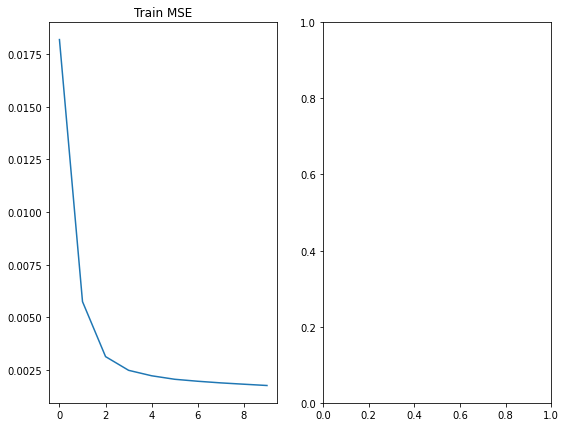

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 7))
ax1.plot(epochs_losses_train)
# ax1.set_yscale("log") 
ax1.set_title("Train MSE")
# ax2.plot(epochs_losses_val, 'orange')
# ax2.set_title("Validation MSE")

In [8]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "C:\\Users\\nikos\\Desktop\\denoising\\new_model_tests\\alt-mask-test-3-both.pth")


In [12]:
# from time import sleep
# sleep(60*2)
# os.system("shutdown -l")
